In [95]:
# Initialize Otter
import otter
grader = otter.Notebook("lab6.ipynb")

---

<h1><center>SDSE Lab 6 <br><br> Ensemble methods and hyperparameter tuning </center></h1>

---




In this lab exercise we will apply several classification models to a problem in astrophysics. The problem is described [here](https://satyam5120.medium.com/predicting-a-pulsar-star-using-different-machine-learning-algorithms-d22ee8fc71b4) and [here](https://www.kaggle.com/datasets/colearninglounge/predicting-pulsar-starintermediate). It consists in labeling observations of space objects as either "pulsars" or "not pulsars", based on the properties of a so-called integrated profile and the DM-SNR curve. The definitions of an "integrated profile" and of the "DM-SNR curve" are not important for this activity.

The dataset has 8 feature columns:
1. Mean of the integrated profile.
2. Standard deviation of the integrated profile.
3. Excess kurtosis of the integrated profile.
4. Skewness of the integrated profile.
5. Mean of the DM-SNR curve.
6. Standard deviation of the DM-SNR curve.
7. Excess kurtosis of the DM-SNR curve.
8. Skewness of the DM-SNR curve.

Our goal is to choose a classification model from the ones covered in this class. The procedure will follow these steps:
1. Load the data.
2. Remove null values.
3. Compute the number of samples per class.
4. Extract a test dataset.
5. Build models:
    + Logistic regression
    + Random forest
    + AdaBoost
    + Gradient Boosted Trees
6. Select and evaluate a final model.

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lab6_utils import unpack_gridsearch, plot_grid_result
from hashutils import *
rng_seed = 2434

# 1. Load the data

+ Load the data file `pulsar_data.csv` into a Pandas dataframe.
+ Save the column headers corresponding to feature names (all except the `target_class`) to the variable `feature_names`.

**Hints**:

+ [`pd.read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)
+ [`DataFrame.columns`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.columns.html)

In [97]:
rawdata = pd.read_csv('pulsar_data.csv')
feature_names = rawdata.columns[:-1]

rawdata.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [98]:
grader.check("q1")

q1 results: All test cases passed!

# 2. Remove null values

Remove any feature columns of `rawdata` with more than zero null values. Store the resulting DataFrame as `cleandata`. Do not modify `rawdata`.

**Hints**: 

+ [`DataFrame.copy`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html)
+ [`np.any`](https://numpy.org/doc/stable/reference/generated/numpy.any.html)
+ [`pd.isnull`](https://pandas.pydata.org/docs/reference/api/pandas.isnull.html)  
+ [`DataFrame.drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) 

In [99]:
cleandata = rawdata.copy()
null_features = [np.any(pd.isnull(cleandata.loc[:, feature])) for feature in feature_names]
cleandata = cleandata.drop(columns=feature_names[null_features])
cleandata['target_class'] = cleandata['target_class'].astype(int)
cleandata.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,target_class
0,121.156250,48.372971,-0.013165,3.168896,7.449874,0
1,76.968750,36.175557,3.388719,2.399666,9.414652,0
2,130.585938,53.229534,-0.297242,2.743311,8.508364,0
3,156.398438,48.865942,-0.171294,17.471572,2.958066,0
4,84.804688,36.117659,3.274125,2.790134,8.405008,0


In [100]:
grader.check("q2")

q2 results: All test cases passed!

# 3. Number of samples per class
Find the number of data points in each of the two classes. Use these variable names:
+ `N0`... number of samples of class 0 (not a pulsar), 
+ `N1`... number of samples of class 1 (pulsar). 





What is the minimum accuracy expected of any non-trivial model? Save your answer to the variable `baseline_acc`.

In [101]:
N0 = cleandata['target_class'].value_counts().get(0)
N1 = cleandata['target_class'].value_counts().get(1) 
baseline_acc = N0 / (N0 + N1)

In [102]:
grader.check("q3")

q3 results: All test cases passed!

# 4. Extract the test dataset

Use Scikit-learn's `train_test_split` method to split `cleandata` into trainging and testing parts. Keep 90% for training and 10% for testing. 

**Notes**: 
+ Pass `random_state=rng_seed` to `train_test_split` so that the result is repeatable.

In [103]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(cleandata.iloc[:, :-1],
                                                cleandata.iloc[:, -1],
                                                test_size=0.1,
                                                random_state=rng_seed)

In [104]:
grader.check("q4")

q4 results: All test cases passed!

# 5. Logistic regression 

This is a binary classification problem, so it makes sense to begin with logistic regression. 

## 5.1. Training

In a previous lab we found that logistic regression can benefit from a normalization (or scaling) of the inputs. 
Create a pipeline that includes a `StandardScaler` (name it `'scaler'`), followed by `LogisticRegression` model (name it `'model'`). 

The logistic regression model should be created with these parameters:
+ `solver='liblinear'`
+ `random_state=rng_seed`

Train the model. 

**Note**: 
+ Import Scikit-learn's `Pipeline`, `LogisticRegression`, and `StandardScaler` classes.

In [105]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

logreg_pipe = Pipeline([('scaler' , StandardScaler()),
                        ('model' , LogisticRegression(solver='liblinear',
                                                      random_state=rng_seed))])

logreg_pipe.fit(Xtrain, ytrain)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(random_state=2434, solver='liblinear'))])

In [106]:
grader.check("q5p1")

q5p1 results: All test cases passed!

## 5.2. Hyperparameter tuning with grid search

To solve an optimization problem by "grid search" is to exhaustively search for a solution over a grid of points covering the feasible space. The "hyperparameter tuning problem" is to select the values of the hyperparameters that maximize the performance of the model. In this section we will solve the hyperparameter tuning problem with grid search. Each setting of the hyperparameters will be evaluated using K-fold cross-validation (as opposed to a validation dataset).

Scikit-learn provides an implementation of grid search with K-fold cross-validation in the [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class. See the documentation of this class for a detailed explanation. 

Our model will be the logistic regression pipeline from part 5.1. The hyperparameters and values to search over are the following. 

+ `penalty`: the regularization function. Try `'l1'` (LASSO) and `'l2'` (Ridge).
+ `C`: the regularization weight. This is equivalent to $1/\lambda$ in our notation. Try five logarithmically spaced values between 0.001 and 10 (i.e. $10^{-3}$, $10^{-2}$, $10^{-1}$, $1$, and $10$). 

Running grid search with Scikit-learn involves two steps: creating the `GridSearchCV` object, and then executing the algorithm with the `fit` method. Create a `GridSearchCV` with these arguments:
+ `param_grid=param_grid`. See explanation below.
+ `scoring='accuracy'`. Use accuracy as the performance metric.
+ `cv=3`. K=3 folds
+ `refit='accuracy'`. Train a final "best model" with the optimal hyperparameters and all of the training data. 

The list of candidate values for each of the hyperparameters is passed to `GridSearchCV` as a dictionary (`param_grid`) with key:value pairs parmeter name:list of parameter values. When working with a pipeline, the parameter name must be prefixed with the name of the model ('model' in our case), and two underscores (`__`). Hence the `param_grid` argument to  `GridSearchCV` should look like this:

```python
param_grid = {
    'model__penalty' : ...,
    'model__C' : ... }
```


The second step is to run the grid search algorithm passing the training data to the `fit` method on the `GridSearchCV` object. 

Implement grid search in the cell below.

**Note**: 

+ Import Scikit-learn's `GridSearchCV` class

In [107]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__penalty' : ['l1', 'l2'],
    'model__C' : [10**-3, 10**-2, 10**-1, 1, 10]
}

gs_logreg = GridSearchCV(estimator=logreg_pipe,
                         param_grid=param_grid,
                         scoring='accuracy',
                         cv=3,
                         refit='accuracy')
gs_logreg.fit(Xtrain, ytrain)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(random_state=2434,
                                                           solver='liblinear'))]),
             param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10],
                         'model__penalty': ['l1', 'l2']},
             refit='accuracy', scoring='accuracy')


`lab6_utils.py` contains useful functions for unpacking and plotting the result of the grid search. 

Below we use the `unpack_gridsearch` method to extract information from the grid search solution. This method returns a dictionary with the following entries:
+ `scoregrid`: The values of the accuracies over the hyperparameter grid. 
+ `best_params`: A dictionary with the best-case hyperparameter values.
+ `best_model`: The logistic regression pipeline corresponding to the best hyperparameters. 
+ `best_score`: The accuracy of the best model.

`plot_grid_result` plots the results of the grid search.


<!-- X, best_params, best_estimator, best_score -->

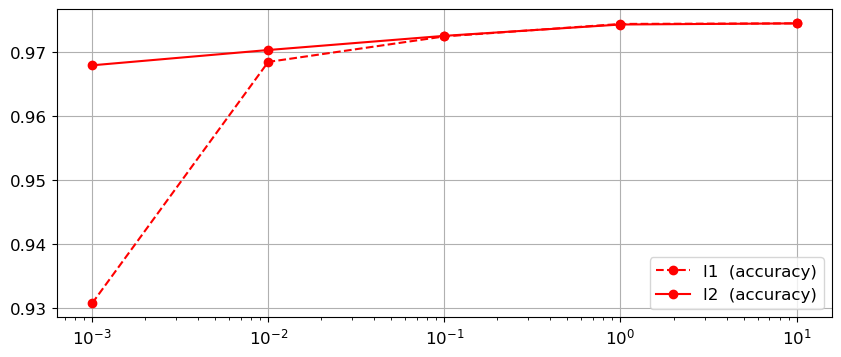

In [108]:
logreg_result = unpack_gridsearch(gs_logreg)
plot_grid_result(logreg_result)

In [109]:
grader.check("q5p2")

q5p2 results: All test cases passed!

## 5.3. Package it into a function

Next we will repeat this process with several other classification models. To keep the code clean, we will first collect the steps into a single function, which we'll call `hypersolve`. This function receives as inputs:
1. The classifier object, e.g. `LogisticRegression(solver='liblinear',random_state=rng_seed)`
2. The `param_grid` dictionary that defines the search space for `GridSearchCV`.

It should:
1. Create a pipeline containing a standard scaler and the model.
2. Construct the `GridSearchCV` object as was done in part 5.2
3. Run the grid se

Run `fit` on the grid search object, using the training data
4. Run `unpack_gridsearch` the dictionary with results.
5. Plot the result with `plot_grid_result`
6. Return the `result` dictionary.


**Note**: This part has no autograder test. Failures in subsequent parts may be due to errors in `hypersolve`.

In [110]:
def hypersolve(model,param_grid):
    # 1. Create the pipeline model
    pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model)
    ])

    # 2. Construct the `GridSearchCV` object as was done in part 5.2
    gs = GridSearchCV(estimator=pipe,
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=3,
                      refit='accuracy')
    
    # 3. Run the grid search
    gs = gs.fit(Xtrain, ytrain)
    
    # 4. Run `unpack_gridsearch` to obtain the results dictionary.
    result = unpack_gridsearch(gs)

    # 5. Plot the result with `plot_grid_result`
    plot_grid_result(result)

    # 6. return result
    return result

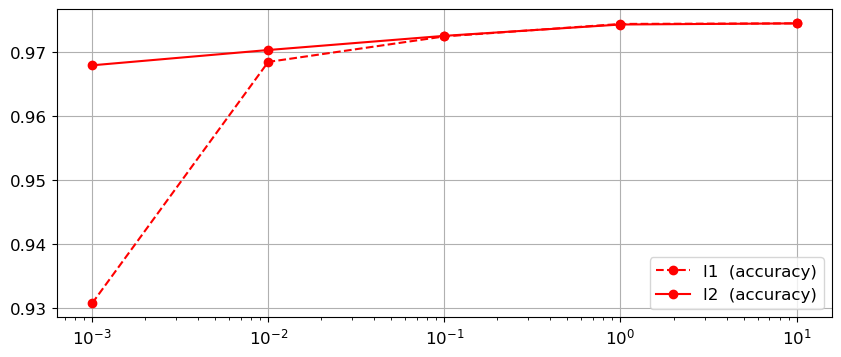

{'scoregrid': {'l1':         mean_test_score
  0.001          0.930731
  0.010          0.968514
  0.100          0.972505
  1.000          0.974457
  10.000         0.974545,
  'l2':         mean_test_score
  0.001          0.967982
  0.010          0.970377
  0.100          0.972594
  1.000          0.974368
  10.000         0.974545},
 'best_params': {'model__C': 10, 'model__penalty': 'l1'},
 'best_estimator': Pipeline(steps=[('scaler', StandardScaler()),
                 ('model',
                  LogisticRegression(C=10, penalty='l1', random_state=2434,
                                     solver='liblinear'))]),
 'best_score': 0.9745452732376717,
 'param_grid': {'model__penalty': ['l1', 'l2'],
  'model__C': [0.001, 0.01, 0.1, 1, 10]}}

In [111]:
# test your code
hypersolve(LogisticRegression(solver='liblinear', random_state=rng_seed), param_grid)

# 6. Random forest

Use grid search to optimize a random forests model over the following parameter ranges:
+ `max_features`: This is the number of features to search over when splitting a node. Test 3 features and all features. 
+ `n_estimators`: Test 2, 42, and 82 trees. 

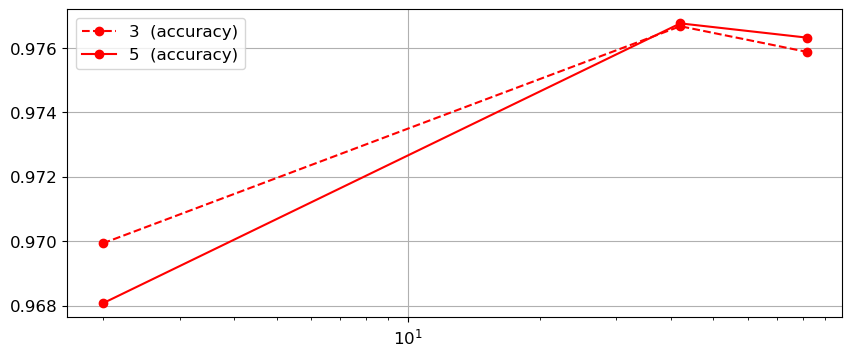

In [112]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'model__max_features' : [3, Xtrain.shape[1]],
    'model__n_estimators' : [2, 42, 82]
}

model = RandomForestClassifier(random_state=rng_seed)

result_rf = hypersolve(model, param_grid_rf)

In [113]:
grader.check("q6")

q6 results: All test cases passed!

# 7. AdaBoost

Repeat the grid search, this time using an AdaBoost model. Use the following values for the parameter grid:
+ `learning_rate: [0.01,0.1]`. $\lambda$ in the notation of the lecture.
+ `n_estimators: [20,60,100]`. $M$ in the notation of the lecture, unless perfect prediction is reached earlier. 

**Note**: 

+ Remember to set the random state for the model in the model's constructor.

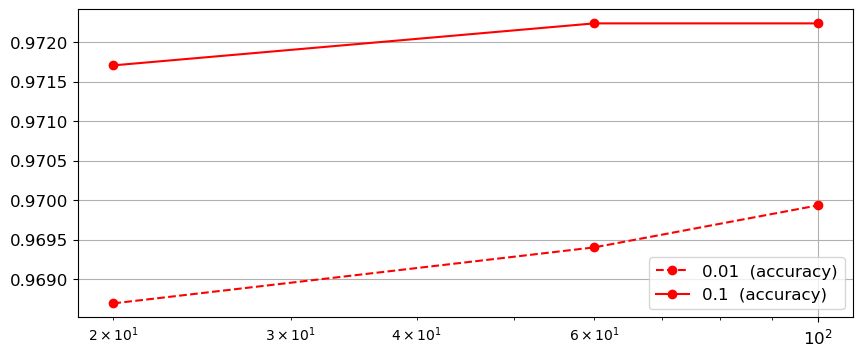

In [114]:
from sklearn.ensemble import AdaBoostClassifier

param_grid_ab = {
    'model__learning_rate' : [0.01, 0.1],
    'model__n_estimators' : [20, 60, 100]
}

model = AdaBoostClassifier(random_state=rng_seed)

result_ab = hypersolve(model, param_grid_ab)

In [115]:
grader.check("q7")

q7 results: All test cases passed!

# 8. Gradient Boosted Trees

Use the following parameters for the hyper-parameter search. These have the same role as in AdaBoost.
+ `learning_rate: [0.01,0.1]`. 
+ `n_estimators: [20,60,100]`. 

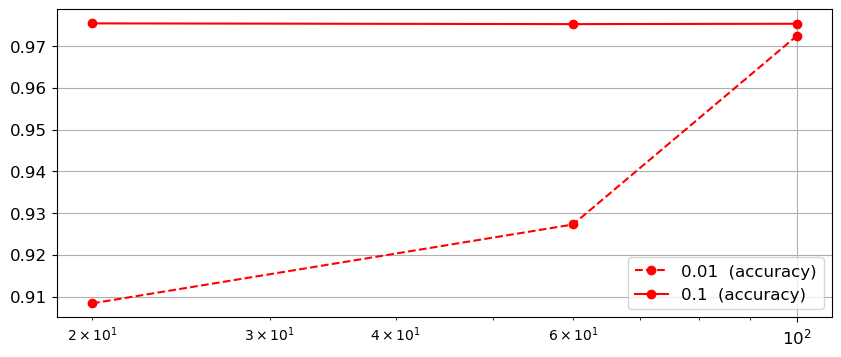

In [116]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gbt = {
    'model__learning_rate' : [0.01, 0.1],
    'model__n_estimators' : [20, 60, 100]
}

model = GradientBoostingClassifier(random_state=rng_seed)

result_gbt = hypersolve(model, param_grid_gbt)

In [117]:
grader.check("q8")

q8 results: All test cases passed!

# 9. Final model selection

We have now built four separate classifiers: logistic regression, random forest, AdaBoost, and Gradient boosted trees. These are stored below in the `all_models` list. Select from this ist the classifier with the best score. Save the corresponding name, model, and score to variables `best_name`, `best_model`, and `best_score` respectively. Then compute the test accuracy for that model, using its `predict` and `accuracy_score` functions. Store the result as `test_accuracy`.

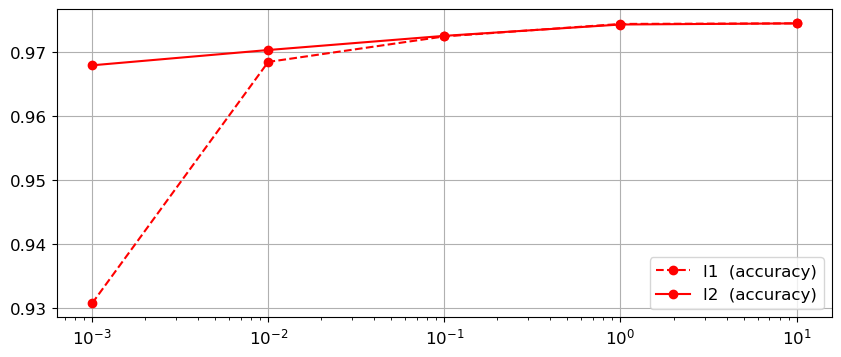

In [118]:
from sklearn.metrics import accuracy_score

# re-solve logistic regression
param_grid_lr = {
    'model__penalty' : ['l1','l2'],
    'model__C' : np.logspace(-3, 1, 5) }
result_lr = hypersolve( LogisticRegression(solver='liblinear',random_state=rng_seed), param_grid_lr)

all_models = [
    ('logreg',result_lr['best_estimator'], result_lr['best_score']),
    ('rf',result_rf['best_estimator'], result_rf['best_score']),
    ('ab',result_ab['best_estimator'], result_ab['best_score']),
    ('gbt',result_gbt['best_estimator'], result_gbt['best_score']),
]

In [119]:
best_index = np.argmax([all_models[mod][-1] for mod in range(len(all_models))])
best_name = all_models[best_index][0]
best_model = all_models[best_index][1]
best_score = all_models[best_index][2]

ypred = best_model.predict(Xtest)
test_accuracy = accuracy_score(y_true=ytest, y_pred=ypred)
test_accuracy

0.9760574620909817

In [120]:
grader.check("q9")

q9 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [121]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)